In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense   # standard neural network
from keras.layers import LSTM    # long-short term memory layer
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, StratifiedKFold

## part 1. datasets

### import training data

In [2]:
model_input = pd.read_csv('training_input (IQVIA derivation dataset).csv')
model_input.shape

(2142, 1877)

In [3]:
# check for any NaN
model_input.isnull().values.any()

False

In [4]:
# seperate dataset-features vs. target
model_input = model_input.drop(['patient_id','cohort_type'], axis = 1) # features

target_map = {u'1': 1, u'0': 0}
model_input['__target__'] = model_input['cohort_flag'].map(str).map(target_map) # target

# drop un-nessary columns
model_input = model_input.drop(['cohort_flag'], axis = 1)

potential_target_leaks = ['cardiomyopathy_in_diseases_classified_elsewhere','other_forms_of_heart_disease']
model_input_flt_leaks = model_input.drop(potential_target_leaks, axis = 1)

# cleaned-up training dataset for analysis
print(model_input_flt_leaks.shape)
model_input_flt_leaks.head(3)

(2142, 1873)


,abdominal_and_pelvic_pain,abdominal_aortic_aneurysm__without_rupture,abdominal_distension__gaseous_,abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton,abnormal_and_inconclusive_findings_on_dx_imaging_of_breast,abnormal_blood_pressure_reading__without_diagnosis,abnormal_coagulation_profile,abnormal_electrocardiogram__ecg___ekg_,abnormal_finding_of_blood_chemistry__unspecified,abnormal_findings_on_diagnostic_imaging_and_in_function_studies__without_diagnosis,...,vomiting__unspecified,vomiting_without_nausea,weakness,wheezing,white_matter_disease__unspecified,wtrcraft_fall_nos_crew,xerosis_cutis,zoster__herpes_zoster_,zoster_without_complications,__target__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### import validation data

In [5]:
# Creating Cariac Validation Cohort
ca_validation_df = pd.read_csv('ca_validation_group_input (IQVIA validation dataset).csv')
ca_validation_df = ca_validation_df.set_index('patient_id')
out_ca_validation_df = ca_validation_df['codes'].str.split(',',expand = True).stack()
out_ca_validation_df.index = out_ca_validation_df.index.droplevel(-1)
out_ca_validation_df = pd.DataFrame(out_ca_validation_df,columns = ['codes'])
out_ca_validation_df = out_ca_validation_df.reset_index()
out_ca_validation_df['type'] = 2

# Mask Patient IDs and generate Caridac Validation Input
pat_map = out_ca_validation_df['patient_id'].drop_duplicates().reset_index(drop=True).reset_index()                                         
pat_map = pat_map.rename(columns = {"index":"new_pat_id"})
final_ca_validation_df = out_ca_validation_df.merge(pat_map,how='inner',on='patient_id')  
final_ca_validation_df = final_ca_validation_df.drop('patient_id',axis=1)                                                                 
final_ca_validation_df = final_ca_validation_df.rename(columns = {"new_pat_id":"patient_id"})
final_ca_validation_df = final_ca_validation_df[['patient_id','type','codes']]
final_ca_validation_df.to_csv('ca_validation_model_input.csv',index = False)

# load dataset and correlated map, feature files
input_df_pre = pd.read_csv('ca_validation_model_input.csv')
icd_map_df = pd.read_csv('icd_map.csv')
ft_imp_df = pd.read_csv('feature_importance.csv')
ft_list_df = pd.DataFrame(ft_imp_df['feature'])

# diagnosis count
input_df = input_df_pre
diagnosis_count = pd.DataFrame({'diag_count' : input_df.groupby('patient_id').count().codes}).reset_index()

amyloidosis_flag = input_df
amyloidosis_flag['E85_flag'] = np.where(input_df['codes']=='E85','1','0')
amyloidosis_flag['E850_flag'] = np.where(input_df['codes']=='E850','1','0')
amyloidosis_flag['E851_flag'] = np.where(input_df['codes']=='E851','1','0')
amyloidosis_flag['E852_flag'] = np.where(input_df['codes']=='E852','1','0')
amyloidosis_flag['E853_flag'] = np.where(input_df['codes']=='E853','1','0')
amyloidosis_flag['E854_flag'] = np.where(input_df['codes']=='E854','1','0')
amyloidosis_flag['E858_flag'] = np.where(input_df['codes']=='E858','1','0')
amyloidosis_flag['E8581_flag'] = np.where(input_df['codes']=='E8581','1','0')
amyloidosis_flag['E8582_flag'] = np.where(input_df['codes']=='E8582','1','0')
amyloidosis_flag['E8589_flag'] = np.where(input_df['codes']=='E8589','1','0')
amyloidosis_flag['E859_flag'] = np.where(input_df['codes']=='E859','1','0')

amy_E85 = pd.DataFrame({'max_E85_flag' : amyloidosis_flag.groupby('patient_id')['E85_flag'].max()}).reset_index()
amy_E850 = pd.DataFrame({'max_E850_flag' : amyloidosis_flag.groupby('patient_id')['E850_flag'].max()}).reset_index()
amy_E851 = pd.DataFrame({'max_E851_flag' : amyloidosis_flag.groupby('patient_id')['E851_flag'].max()}).reset_index()
amy_E852 = pd.DataFrame({'max_E852_flag' : amyloidosis_flag.groupby('patient_id')['E852_flag'].max()}).reset_index()
amy_E853 = pd.DataFrame({'max_E853_flag' : amyloidosis_flag.groupby('patient_id')['E853_flag'].max()}).reset_index()
amy_E854 = pd.DataFrame({'max_E854_flag' : amyloidosis_flag.groupby('patient_id')['E854_flag'].max()}).reset_index()
amy_E858 = pd.DataFrame({'max_E858_flag' : amyloidosis_flag.groupby('patient_id')['E858_flag'].max()}).reset_index()
amy_E8581 = pd.DataFrame({'max_E8581_flag' : amyloidosis_flag.groupby('patient_id')['E8581_flag'].max()}).reset_index()
amy_E8582 = pd.DataFrame({'max_E8582_flag' : amyloidosis_flag.groupby('patient_id')['E8582_flag'].max()}).reset_index()
amy_E8589 = pd.DataFrame({'max_E8589_flag' : amyloidosis_flag.groupby('patient_id')['E8589_flag'].max()}).reset_index()
amy_E859 = pd.DataFrame({'max_E859_flag' : amyloidosis_flag.groupby('patient_id')['E859_flag'].max()}).reset_index()

x = input_df['patient_id'].nunique()

input_df['ca_flag'] = np.where(input_df['codes']=='E8582','1',np.where(input_df['codes']=='E854','1','0'))
ca_pt = input_df[input_df['ca_flag'] == '1']
ca_pt_id = ca_pt['patient_id']
input_df['hf_flag'] = np.where(input_df['codes']=='I504','1',np.where(input_df['codes']=='I508','1',np.where(input_df['codes']=='I5081','1',np.where(input_df['codes']=='I50','1',np.where(input_df['codes']=='I501','1',np.where(input_df['codes']=='I502','1',np.where(input_df['codes']=='I5020','1',np.where(input_df['codes']=='I5021','1',np.where(input_df['codes']=='I5022','1',np.where(input_df['codes']=='I5023','1',np.where(input_df['codes']=='I503','1',np.where(input_df['codes']=='I5030','1',np.where(input_df['codes']=='I5031','1',np.where(input_df['codes']=='I5032','1',np.where(input_df['codes']=='I5033','1',np.where(input_df['codes']=='I5040','1',np.where(input_df['codes']=='I5041','1',np.where(input_df['codes']=='I5042','1',np.where(input_df['codes']=='I5043','1',np.where(input_df['codes']=='I50810','1',np.where(input_df['codes']=='I50811','1',np.where(input_df['codes']=='I50812','1',np.where(input_df['codes']=='I50813','1',np.where(input_df['codes']=='I50814','1',np.where(input_df['codes']=='I5082','1',np.where(input_df['codes']=='I5083','1',np.where(input_df['codes']=='I5084','1',np.where(input_df['codes']=='I5089','1',np.where(input_df['codes']=='I509','1','0')))))))))))))))))))))))))))))
hf_pt = input_df[input_df['hf_flag'] == '1']
hf_pt_id = hf_pt['patient_id']
df_cd = pd.merge(input_df,ca_pt_id, how='inner', on = 'patient_id')

pt_hf_flag = pd.DataFrame({'max_hf_flag' : df_cd.groupby('patient_id')['hf_flag'].max()}).reset_index()
pt_input_hf_flag = pd.DataFrame({'max_hf_flag' : input_df.groupby('patient_id')['hf_flag'].max()}).reset_index()
pt_hf_flag_0 = pt_hf_flag[pt_hf_flag['max_hf_flag']=='0']
total_pat = input_df['patient_id'].nunique()
ca_pat_count = ca_pt_id.nunique()
hf_pat_count = hf_pt_id.nunique()
ca_without_hf = pt_hf_flag_0['patient_id'].nunique()
ca_final_patient_df = pt_hf_flag[pt_hf_flag['max_hf_flag']!='0']
final_patient_df = pt_input_hf_flag[pt_input_hf_flag['max_hf_flag']!='0']
ca_final_pat_id = ca_final_patient_df['patient_id']
final_pat_id= final_patient_df['patient_id']
final_input_df = pd.merge(input_df,final_pat_id, how='inner', on = 'patient_id')

final_input_df = final_input_df[['patient_id','codes','type']]

hf_pt_count = hf_pat_count-(ca_pat_count - ca_without_hf)
ca_pt_count = ca_pat_count - ca_without_hf

print("A total of " + str(total_pat) + " patients were found. Out of which we discovered " + str(ca_pat_count - ca_without_hf)  + " as Cardiac Amyloid patients and a total of " + str(hf_pat_count-(ca_pat_count - ca_without_hf))  + " Heart Failure Patients.")

A total of 15394 patients were found. Out of which we discovered 7697 as Cardiac Amyloid patients and a total of 7697 Heart Failure Patients.


In [6]:
# define fx for preprocess
dtype1 = dict(codes = str, type = str)
potential_target_leaks = ['cardiomyopathy_in_diseases_classified_elsewhere','other_forms_of_heart_disease']

def preprocess(df):    
    def mis_val(df):
        print ("Count of NA's \n",df.isnull().sum())
        nans = lambda df: df[df.isnull().any(axis=1)]
        print ("\n Rows with NA's \r\n", nans(df))
        df_wo_na = df.dropna()
        return df_wo_na
    
    df_cln = mis_val(df)
    
    def icd_fix(icd_version):
        conditions =  (icd_version.str.contains('10'))| (icd_version == '2'),(icd_version.str.contains('9'))| (icd_version == '1')
        choices = ['ICD10', 'ICD9']
        icd_fix = np.select(conditions, choices, default='NA')
        return icd_fix
    
    df_cln['type_fix'] = icd_fix(df_cln[vers_type])    
    df_map = pd.merge(df_cln,icd_map_df,left_on=["type_fix",codes],right_on=["type","codes"] ,how = 'left')    
    df_map_cln = mis_val(df_map)        
    keys = ['short_desc','major','sub_chapter']
    df_feature = df_map_cln.melt(id_vars= ptid,value_vars=keys,var_name= 'source',value_name='feature') #different syntax in lower versions
    
    features = pd.DataFrame(df_feature['feature'].drop_duplicates())    
    features['feature_cln'] = features['feature'].str.lower().str[:100].replace(to_replace="[^A-Za-z0-9]", value="_", regex=True)
    
    df_feature = df_feature.merge(features,on = 'feature',how='inner')    
    df_feature = df_feature.drop(['feature'],axis=1)    
    df_feature_fitler = pd.merge(ft_list_df,df_feature,left_on = 'feature',right_on= 'feature_cln',how= 'left')    
    df_feature_cols = df_feature_fitler[[ptid,'feature']].copy()    
    df_feature_cols['presence_flag'] = '1'    
    df_ft_pivot = df_feature_cols.pivot_table(index=ptid, columns='feature', values='presence_flag', aggfunc=np.max,dropna = False,fill_value = '0')

    return df_ft_pivot

In [7]:
# preprocess the input dataset

# enter name for corresponding var
ptid = 'patient_id'  # patient id
vers_type = 'type'   # ICD code version type column
codes = 'codes'      # ICD code column

final_df = preprocess(final_input_df.astype(dtype1))

Count of NA's 
 patient_id    0
codes         0
type          0
dtype: int64

 Rows with NA's 
 Empty DataFrame
Columns: [patient_id, codes, type]
Index: []
Count of NA's 
 patient_id         0
codes              0
type_x             0
type_fix           0
type_y          1294
version_type    1294
short_desc      1294
major           1294
sub_chapter     1294
dtype: int64

 Rows with NA's 
          patient_id codes type_x type_fix type_y  version_type short_desc  \
4901             21    -1      2    ICD10    NaN           NaN        NaN   
7263             32    -1      2    ICD10    NaN           NaN        NaN   
8409             41    -1      2    ICD10    NaN           NaN        NaN   
8559             42    -1      2    ICD10    NaN           NaN        NaN   
9719             46    -1      2    ICD10    NaN           NaN        NaN   
...             ...   ...    ...      ...    ...           ...        ...   
1916157       15104    -1      2    ICD10    NaN           NaN     

In [8]:
final_df.shape

(15394, 1872)

In [9]:
# working on y_test for final_df
flag_pt = pd.DataFrame()
final_input_df['cohort_flag'] = np.where(final_input_df["codes"]== 'E8582' , '1',np.where(final_input_df["codes"]== 'E854' , '1','0'))
flag = final_input_df[final_input_df['cohort_flag'] == '1']
flag_pt['patient_id'] = flag['patient_id']
flag_pt =flag_pt.drop_duplicates()
flag_pt['cohort_flag']  = '1'

flag_pt.head()

,patient_id,cohort_flag
409,1,1
572,2,1
2024,5,1
2313,6,1
2792,9,1


In [10]:
target_map = {u'1': 1, u'0': 0}
model_file = joblib.load('rf_best_excl_1_CM_3_6.sav')

rf_random_predictions = model_file.predict(final_df)
rf_random_probas = model_file.predict_proba(final_df)

rf_random_predictions = pd.Series(data=rf_random_predictions, index=final_df.index, name='predicted_value')
cols = [
    u'probability_of_value_%s' % label
    for (_, label) in sorted([(int(target_map[label]), label) for label in target_map])
]

rf_random_probabilities = pd.DataFrame(data=rf_random_probas, index=final_df.index, columns=cols)
results_test_rf_random = pd.concat([rf_random_predictions,rf_random_probabilities],axis=1)
results_test_rf_random.reset_index(level=0, inplace=True)

df_cd = pd.merge(flag_pt, results_test_rf_random, how='outer', on = 'patient_id')
final = df_cd[['patient_id','cohort_flag','predicted_value','probability_of_value_0','probability_of_value_1']]

final['cohort_f'] = np.where(final["cohort_flag"]== '1', 1,0)
final_cohort = final
final = final.fillna(0)

final = pd.merge(final, diagnosis_count, how='left', on = 'patient_id')

final = pd.merge(final, amy_E85, how='left', on = 'patient_id')
final = pd.merge(final, amy_E850, how='left', on = 'patient_id')
final = pd.merge(final, amy_E851, how='left', on = 'patient_id')
final = pd.merge(final, amy_E852, how='left', on = 'patient_id')
final = pd.merge(final, amy_E853, how='left', on = 'patient_id')
final = pd.merge(final, amy_E854, how='left', on = 'patient_id')
final = pd.merge(final, amy_E858, how='left', on = 'patient_id')
final = pd.merge(final, amy_E8581, how='left', on = 'patient_id')
final = pd.merge(final, amy_E8582, how='left', on = 'patient_id')
final = pd.merge(final, amy_E8589, how='left', on = 'patient_id')
final = pd.merge(final, amy_E859, how='left', on = 'patient_id')

final_df_bu = final_df
final_df_bu['patient_id'] = final_df.index
final_df_bu = final_df_bu.reset_index(drop=True)

final_df_wFlag = final_df_bu.join(final['cohort_f'],on='patient_id',how='outer')
final_df_wFlag.set_index('patient_id')
final_df_wFlag.index.name = 'patient_id'
final_df_wFlag = final_df_wFlag.drop(['patient_id'],axis=1)

final_df_wFlag.shape

(15394, 1873)

In [11]:
# save datasets for future use
pd.DataFrame(model_input_flt_leaks).to_csv('model_dataset_filtered.csv')
pd.DataFrame(final_df_wFlag).to_csv('validation_dataset.csv')

## part 2. model built

### repeat the random forest model
#### build model using training dataset

In [12]:
# Splitting model_input into test and train
X = model_input_flt_leaks.drop('__target__', axis=1)
y = np.array(model_input_flt_leaks['__target__'])

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train data has %i rows and %i columns' % (train_X.shape[0], train_X.shape[1]))
print ('Test data has %i rows and %i columns' % (test_X.shape[0], test_X.shape[1]))

Train data has 1713 rows and 1872 columns
Test data has 429 rows and 1872 columns


In [13]:
# random forest model
rfc = RandomForestClassifier(n_estimators=100,  criterion='gini',random_state=123, oob_score=True)
rfc.fit(train_X,train_y)
results = rfc.score(test_X, test_y)
results

0.8344988344988346

In [14]:
# fine-turn model parameters

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 301, num = 5)]
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
min_samples_split = [2,3,5,7]
min_samples_leaf = [2,3,4,5]
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc_grid = GridSearchCV(rfc, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)
rfc_grid.fit(train_X, train_y)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 112, 175, 238, 301]},
             verbose=2)

In [15]:
# best parametersf
rfc_grid.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 112}

In [16]:
# best score
rfc_grid.best_score_

0.8464920805414897

In [64]:
# results
rfc_best = RandomForestClassifier(n_estimators=112, max_depth=20, min_samples_split=2, min_samples_leaf=3, bootstrap=True,criterion='gini', random_state=123, oob_score=True)
rfc_best.fit(train_X,train_y)

rfc_best.score(test_X,test_y)

0.8368298368298368

In [19]:
# roc_auc_score
pred = rfc_best.predict_proba(test_X)
roc_value = roc_auc_score(test_y, pred[:,1])
roc_value

0.9136492066941969

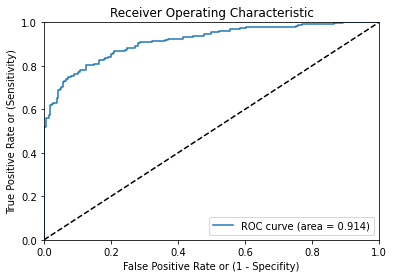

In [20]:
# Compute fpr, tpr, thresholds and roc auc
# y_pred = rfc_best.predict(test_X)
fpr, tpr, thresholds = roc_curve(test_y, pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('ROC_curve_randomForest.png')

[[175  39]
 [ 35 180]]


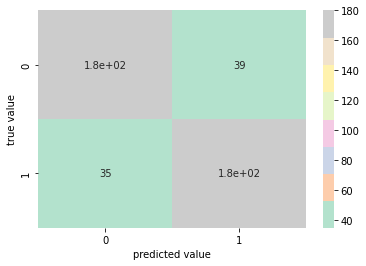

In [21]:
# plot confusion matrix
rfc_predicted = rfc_best.predict(test_X)

cf_matrix = confusion_matrix(test_y,rfc_predicted)
print(cf_matrix)

sns.heatmap(cf_matrix,annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.savefig('randomForest_untuned_conmatrix.png')
plt.show()

In [22]:
print(metrics.classification_report(rfc_predicted, test_y))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       210
           1       0.84      0.82      0.83       219

    accuracy                           0.83       429
   macro avg       0.83      0.83      0.83       429
weighted avg       0.83      0.83      0.83       429



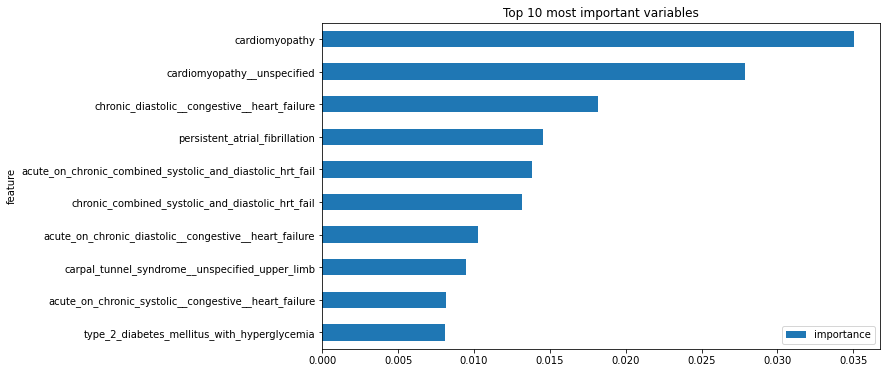

In [23]:
# important features
feature_importances_data = []
features = train_X.columns
for feature_name, feature_importance in zip(features, rfc_best.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# plotting
top_10_features = pd.DataFrame(feature_importances_data).set_index('feature').sort_values(by='importance')[-10::]
top_10_features.plot(title='Top 10 most important variables',
                     kind='barh',
                     figsize=(10, 6))
plt.savefig('top10_important_features.png')

In [24]:
# save the feature important | randomforest model files
pd.DataFrame(feature_importances_data).set_index('feature').sort_values(by='importance').to_csv('feature_importance_indexed_sorted.csv')

## part 3. Test the generacity of random forest model using validation dataset

In [25]:
# accuracy score
X_valid = final_df_wFlag.iloc[:,:1872]
y_valid = final_df_wFlag.iloc[:,-1]
rfc_best.score(X_valid,y_valid)

0.5185137066389502

In [26]:
# define a ROC curve function
def plot_ROC(y_true,y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

[[5163 2534]
 [4878 2819]]


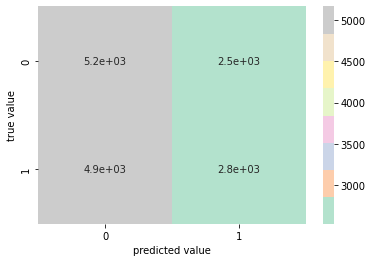

In [27]:
#predict y
rfc_vpred = rfc_best.predict(X_valid)

# confusion matrix
print(confusion_matrix(y_valid,rfc_vpred))
sns.heatmap(confusion_matrix(y_valid,rfc_vpred), annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [28]:
print(metrics.classification_report(rfc_vpred,y_valid))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58     10041
           1       0.37      0.53      0.43      5353

    accuracy                           0.52     15394
   macro avg       0.52      0.52      0.51     15394
weighted avg       0.56      0.52      0.53     15394



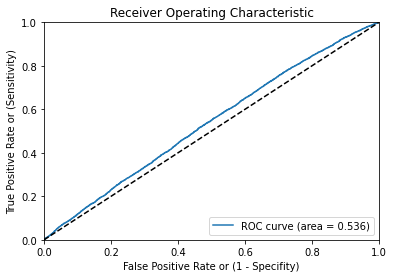

In [29]:
# predict probability
rfc_vpred_p = rfc_best.predict_proba(X_valid)
# auroc
plot_ROC(y_valid,rfc_vpred_p[:,1])

## Part 4. additional data preprocessing for other model builds

In [30]:
# load datasets
model_dat = pd.read_csv('model_dataset_filtered.csv')
model_dat = model_dat.rename(columns={'Unnamed: 0':'patient_id'})
model_dat = model_dat.set_index('patient_id')

valid_dat = pd.read_csv('validation_dataset.csv')
valid_dat = valid_dat.set_index('patient_id')

print(model_dat.shape,valid_dat.shape)

(2142, 1873) (15394, 1873)


In [31]:
print(model_dat.dtypes, valid_dat.dtypes)

abdominal_and_pelvic_pain                                      int64
abdominal_aortic_aneurysm__without_rupture                     int64
abdominal_distension__gaseous_                                 int64
abn_findings_on_dx_imaging_of_abd_regions__inc_retroperiton    int64
abnormal_and_inconclusive_findings_on_dx_imaging_of_breast     int64
                                                               ...  
wtrcraft_fall_nos_crew                                         int64
xerosis_cutis                                                  int64
zoster__herpes_zoster_                                         int64
zoster_without_complications                                   int64
__target__                                                     int64
Length: 1873, dtype: object abdominal_and_pelvic_pain                                      int64
abdominal_aortic_aneurysm__without_rupture                     int64
abdominal_distension__gaseous_                                 int64
abn_fi

In [32]:
# split X and y
X,y=model_dat.iloc[:,:1872], model_dat.iloc[:,-1]
print(X.shape,y.shape)

(2142, 1872) (2142,)


##### unsupervised Agglomerative Clustering

In [33]:
# scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# normalize
X_normalized = normalize(X_scaled)

In [34]:
# reduce dimentionality
pca = PCA(n_components=2, svd_solver='randomized', whiten=True, random_state=1000)
X_principal = pd.DataFrame(pca.fit_transform(X_normalized))
X_principal.columns = ['PC1','PC2']

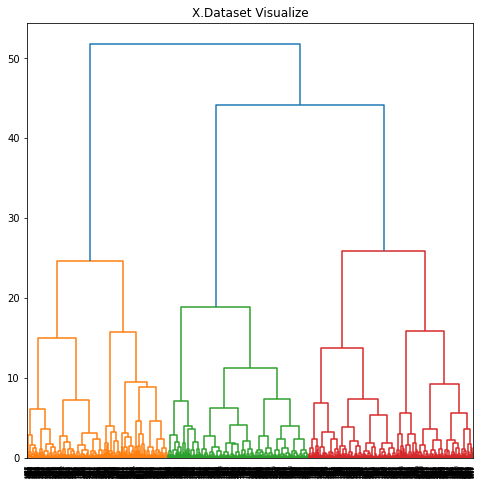

In [35]:
# view dendrograms
plt.figure(figsize=(8,8))
plt.title("X.Dataset Visualize")
Dendrogram = shc.dendrogram(shc.linkage(X_principal, method='ward'))

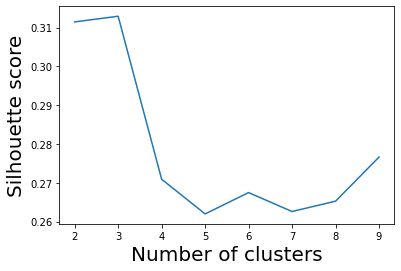

In [36]:
# build k clustering models
sil_scores = []
for k in range(2,10):
    ac = AgglomerativeClustering(n_clusters=k)
    score = silhouette_score(X_principal, ac.fit_predict(X_principal))
    sil_scores.append(score)

# plotting
k=[i for i in range(2,10)]
plt.plot(k,sil_scores)
plt.xlabel("Number of clusters", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.show()

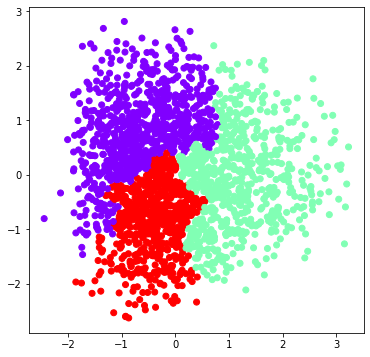

In [37]:
# apply the optimal k number as 3
ac3 = AgglomerativeClustering(n_clusters=3)

# Visualize the cluster
plt.figure(figsize=(6,6))
plt.scatter(X_principal['PC1'], X_principal['PC2'],
           c=ac3.fit_predict(X_principal), cmap='rainbow')
plt.show()

##### PCA-tSNE unsupervised clustering

In [38]:
# copy the dataset as df_cp
df_cp = model_dat.copy()

In [39]:
#tSNE without dimention reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2142 samples in 0.004s...
[t-SNE] Computed neighbors for 2142 samples in 0.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2142
[t-SNE] Computed conditional probabilities for sample 2000 / 2142
[t-SNE] Computed conditional probabilities for sample 2142 / 2142
[t-SNE] Mean sigma: 2.423791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.849274
[t-SNE] KL divergence after 300 iterations: 3.837057


Text(0.5, 1.0, 'tSNE cluster visaluzation')

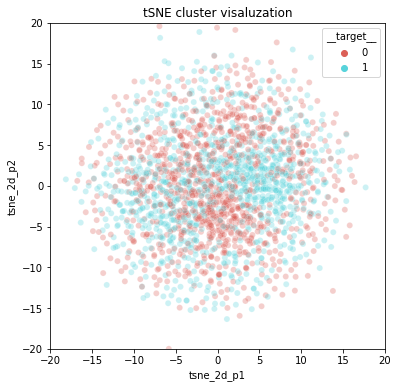

In [40]:
# plotting to see the clusters
df_cp['tsne_2d_p1'] = tsne_results[:,0]
df_cp['tsne_2d_p2'] = tsne_results[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne_2d_p1", y="tsne_2d_p2",
    hue="__target__",
    palette=sns.color_palette("hls", 2),
    data=df_cp,
    legend="full",
    alpha=0.3
)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title("tSNE cluster visaluzation")

Text(0, 0.5, 'cumulative explained variance')

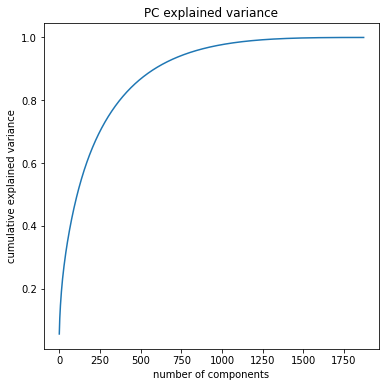

In [41]:
# dimention reduction using PCA
# plot how many pca components could explain '__target__'
pcah=PCA().fit(X)

plt.figure(figsize=(6,6))
plt.plot(np.cumsum(pcah.explained_variance_ratio_))
plt.title('PC explained variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# plt.savefig('PCA_explained_variance.png')

In [42]:
# select 500 component to explain y variable
pca_500 = PCA(n_components=500, svd_solver='randomized', whiten=True, random_state=1000)
pca_500_result = pca_500.fit_transform(X)

print('Cumulative explained variation for 500 principal components: {}'.format(np.sum(pca_500.explained_variance_ratio_)))

Cumulative explained variation for 500 principal components: 0.8653442325480858


In [43]:
# apply 500 pca component as input for tSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(pca_500_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2142 samples in 0.001s...
[t-SNE] Computed neighbors for 2142 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2142
[t-SNE] Computed conditional probabilities for sample 2000 / 2142
[t-SNE] Computed conditional probabilities for sample 2142 / 2142
[t-SNE] Mean sigma: 4.537175
[t-SNE] KL divergence after 250 iterations with early exaggeration: 158.382324
[t-SNE] KL divergence after 1000 iterations: 3.180436


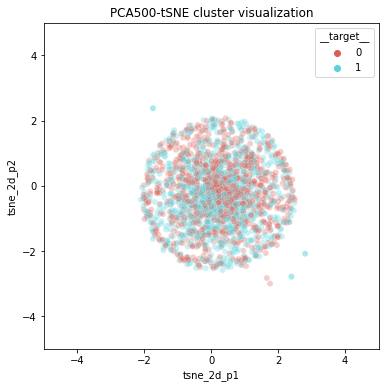

In [45]:
# plotting to see the clusters
df_cp['tsne_2d_p1'] = tsne_results[:,0]
df_cp['tsne_2d_p2'] = tsne_results[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(    
    x="tsne_2d_p1", y="tsne_2d_p2",
    hue="__target__",
    palette=sns.color_palette("hls", 2),
    data=df_cp,
    legend="full",
    alpha=0.3    
)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("PCA500-tSNE cluster visualization")
plt.show()

##### supervised model - pca500-logistic regression model

In [46]:
# split train and test at ratio of 0.8/0.2
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print ('Train data has %i rows and %i columns' % (train_X.shape[0], train_X.shape[1]))
print ('Test data has %i rows and %i columns' % (test_X.shape[0], test_X.shape[1]))

Train data has 1713 rows and 1872 columns
Test data has 429 rows and 1872 columns


In [47]:
# dimention reduction with pca500
pca500 = PCA(n_components=500, svd_solver='randomized', whiten=True, random_state=1000)
pca_X_train = pd.DataFrame(pca500.fit_transform(train_X))
pca_X_test = pd.DataFrame(pca500.transform(test_X))

In [48]:
# model logistic regression, changing the class_weight hyperparameter to account for possible unbalanced classes
lrpca_cls = LogisticRegression(class_weight='balanced')
# training model
lrpca_cls.fit(pca_X_train, train_y)
# predict
lrpca_pred = lrpca_cls.predict(pca_X_test)
lrpca_pred_prb = lrpca_cls.predict_proba(pca_X_test)

In [49]:
# accuracry
lrpca_cls.score(pca_X_test,test_y)

0.8065268065268065

[[156  43]
 [ 40 190]]


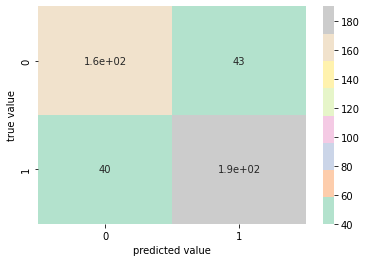

In [51]:
# confusion matrix
print(confusion_matrix(test_y,lrpca_pred))
sns.heatmap(confusion_matrix(test_y,lrpca_pred),annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [52]:
print(metrics.classification_report(lrpca_pred,test_y))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       196
           1       0.83      0.82      0.82       233

    accuracy                           0.81       429
   macro avg       0.81      0.81      0.81       429
weighted avg       0.81      0.81      0.81       429



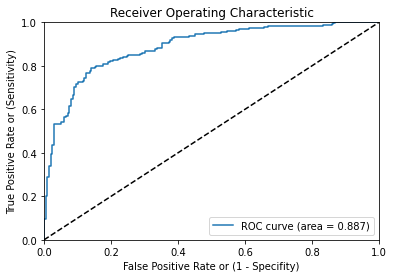

In [53]:
# auroc
plot_ROC(test_y, lrpca_pred_prb[:,1])

In [54]:
# test on validation dataset
# split X and y
valid_X,valid_y=valid_dat.iloc[:,:1872], valid_dat.iloc[:,-1]
print(valid_X.shape,valid_y.shape)

# dimention reduction
pca_X_valid = pd.DataFrame(pca500.transform(valid_X))
# predict
lrpca_pred_val = lrpca_cls.predict(pca_X_valid)
lrpca_pred_prb_val = lrpca_cls.predict_proba(pca_X_valid)

(15394, 1872) (15394,)


In [55]:
# accuracry
lrpca_cls.score(pca_X_valid,valid_y)

0.509029492009874

[[4872 2825]
 [4733 2964]]


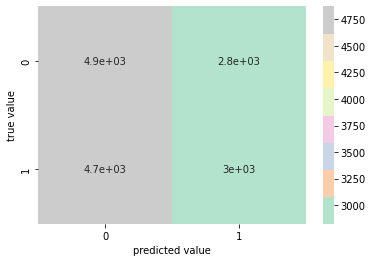

In [56]:
# confusion matrix
print(confusion_matrix(y_valid,lrpca_pred_val))
sns.heatmap(confusion_matrix(y_valid,lrpca_pred_val),annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [57]:
print(metrics.classification_report(lrpca_pred_val,y_valid ))

              precision    recall  f1-score   support

           0       0.63      0.51      0.56      9605
           1       0.39      0.51      0.44      5789

    accuracy                           0.51     15394
   macro avg       0.51      0.51      0.50     15394
weighted avg       0.54      0.51      0.52     15394



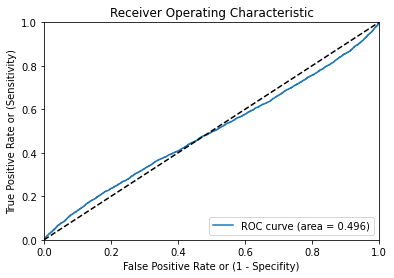

In [58]:
# auroc
plot_ROC(y_valid, lrpca_pred_prb_val[:,1])

##### supervised model - pca-svm

In [59]:
print(X.shape, y.shape)
print(train_X.shape, test_X.shape)

(2142, 1872) (2142,)
(1713, 1872) (429, 1872)


In [60]:
# pca-svm
pca = PCA(n_components=500, svd_solver='randomized', whiten=True, random_state=1000)
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

In [62]:
# fine-tunning the hyper-parameters
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0001, 0.0005, 0.001],
              'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid']              
             }

grid = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)
%time grid.fit(train_X, train_y)

print(grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Wall time: 4min 24s
{'svc__C': 1, 'svc__gamma': 0.0005, 'svc__kernel': 'sigmoid'}


In [65]:
# fit best model 
svcpca_model = grid.best_estimator_
# predicting on test values
svcpca_pred = svcpca_model.predict(test_X)
svcpca_pred_prb = svcpca_model.predict_proba(test_X)

In [66]:
# accuracy
svcpca_model.score(test_X,test_y)

0.8088578088578089

In [67]:
print(metrics.classification_report(svcpca_pred,test_y))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       241
           1       0.73      0.89      0.80       188

    accuracy                           0.81       429
   macro avg       0.81      0.82      0.81       429
weighted avg       0.83      0.81      0.81       429



[[179  20]
 [ 62 168]]


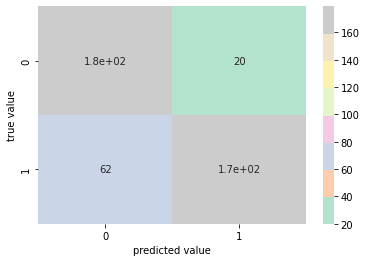

In [68]:
# confusion matrix
print(confusion_matrix(test_y, svcpca_pred))
sns.heatmap(confusion_matrix(test_y, svcpca_pred), annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

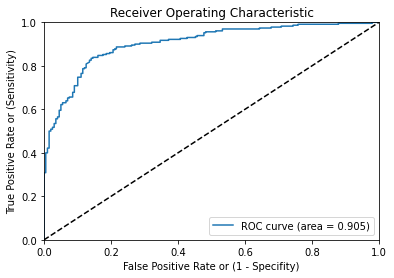

In [69]:
plot_ROC(test_y, svcpca_pred_prb[:,1])

In [70]:
# test generalcity using validation dataset ==
# predicting on test values
svcpca_pred_valid = svcpca_model.predict(valid_X)
svcpca_pred_prb_valid = svcpca_model.predict_proba(valid_X)

In [71]:
# accuracy
svcpca_model.score(valid_X,valid_y)

0.5187735481356373

In [72]:
print(metrics.classification_report(svcpca_pred_valid,valid_y))

              precision    recall  f1-score   support

           0       0.74      0.51      0.61     11171
           1       0.29      0.53      0.38      4223

    accuracy                           0.52     15394
   macro avg       0.52      0.52      0.49     15394
weighted avg       0.62      0.52      0.54     15394



[[5730 1967]
 [5441 2256]]


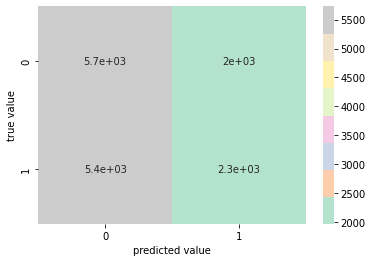

In [73]:
# confusion matrix
print(confusion_matrix(valid_y, svcpca_pred_valid))
sns.heatmap(confusion_matrix(valid_y, svcpca_pred_valid), annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

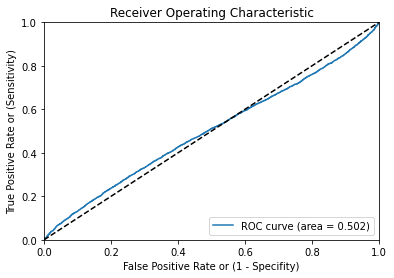

In [74]:
plot_ROC(valid_y, svcpca_pred_prb_valid[:,1])

#####  CNN model

In [75]:
# one hot encoding for y
y_1h = np_utils.to_categorical(y)
y_1h

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [76]:
# split train test subsets with ratio as 0.8/0.2
train_X1h, test_X1h, train_y1h, test_y1h = train_test_split(X,y_1h,test_size=0.2, random_state=1000)
print(train_X1h.shape,test_X1h.shape, train_y1h.shape, test_y1h.shape)

(1713, 1872) (429, 1872) (1713, 2) (429, 2)


In [77]:
# convert to tensor
tf.convert_to_tensor(train_X1h)

<tf.Tensor: shape=(1713, 1872), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)>

In [78]:
# normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_X1h)

In [79]:
# define a basic CNN model
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100, activation='relu'),    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
  ])

  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)
  return model

In [80]:
# fit the model
model_tf = get_basic_model()
history = model_tf.fit(train_X1h, train_y1h, epochs=100, batch_size=64)

Epoch 1/100
27/27 [==============================] - 0s 12ms/step - loss: 0.5777 - accuracy: 0.7046
Epoch 2/100
27/27 [==============================] - 0s 12ms/step - loss: 0.2063 - accuracy: 0.9416
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 0.1005 - accuracy: 0.9743
Epoch 4/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0541 - accuracy: 0.9907
Epoch 5/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0338 - accuracy: 0.9959
Epoch 6/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0224 - accuracy: 0.9977
Epoch 7/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0164 - accuracy: 0.9971
Epoch 8/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0121 - accuracy: 0.9988
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0088 - accuracy: 0.9994
Epoch 10/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0069 - accuracy: 0.9994

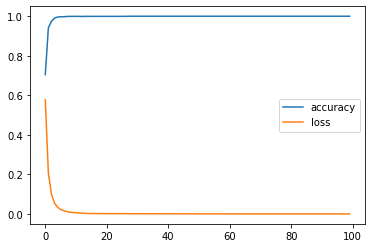

In [81]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.savefig('tf_lossAccuracy.png')
plt.show()

In [82]:
# make predictions
tf_pred = model_tf.predict(test_X1h)
model_tf.evaluate(test_X1h, test_y1h)

14/14 [==============================] - 0s 7ms/step - loss: 0.8975 - accuracy: 0.8065


[0.8975383043289185, 0.806526780128479]

In [83]:
# reverse one-hot encoding to tf_pred_hat
tf_rst = pd.DataFrame(tf_pred)

tf_pred_hat = []
for i in range(tf_rst.shape[0]):
    num = (tf_rst.iloc[i,1] > tf_rst.iloc[i,0]).sum()
    tf_pred_hat.append(num)

tf_pred_hat[:6]

[0, 1, 1, 1, 0, 0]

In [84]:
tf_pred_prb = []
for i in range(tf_rst.shape[0]):
    prb = tf_rst.iloc[i,1]/(tf_rst.iloc[i,1] + tf_rst.iloc[i,0])
    tf_pred_prb.append(prb)

tf_pred_prb[:6]

[0.008423717, 1.0, 1.0, 1.0, 7.5133266e-07, 8.090977e-08]

In [85]:
print(metrics.classification_report(tf_pred_hat,test_y1h[:,1]))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       215
           1       0.80      0.81      0.81       214

    accuracy                           0.81       429
   macro avg       0.81      0.81      0.81       429
weighted avg       0.81      0.81      0.81       429



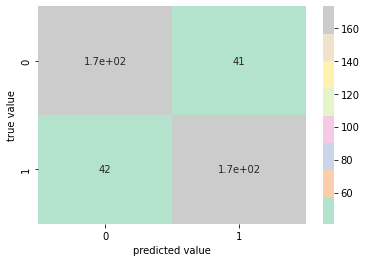

In [86]:
# confusion matrix
print()
sns.heatmap(confusion_matrix(test_y1h[:,1], tf_pred_hat),annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

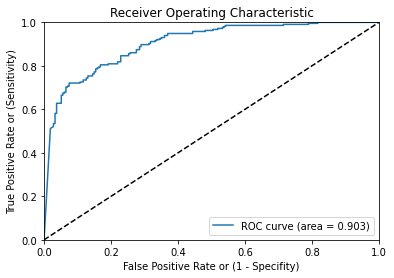

In [87]:
# auroc
plot_ROC(test_y1h[:,1], tf_pred_prb)

In [88]:
#### test on validation dataset
# one-hot-encoding for valid_y
valid_y1h = np_utils.to_categorical(valid_y)

In [89]:
# convert X_valid to tensor
valid_X1h = valid_X.copy()
tf.convert_to_tensor(valid_X1h)
# normalization
normalizer.adapt(valid_X1h) 

In [90]:
# make predictions
tf_pred_valid = model_tf.predict(valid_X1h)
model_tf.evaluate(valid_X1h, valid_y1h)

482/482 [==============================] - 3s 6ms/step - loss: 4.2250 - accuracy: 0.4980


[4.2250189781188965, 0.49798622727394104]

In [91]:
# revser back to one column y_valid and y_pred_valid
y_valid_class = np.argmax(valid_y1h,axis=1)
y_pred_valid_class = np.argmax(tf_pred_valid,axis=1)

In [92]:
# tf_pred_prb_valid
tf_rst = pd.DataFrame(tf_pred_valid)

tf_pred_prb_valid = []
for i in range(tf_rst.shape[0]):
    prb = tf_rst.iloc[i,1]/(tf_rst.iloc[i,1] + tf_rst.iloc[i,0])
    tf_pred_prb_valid.append(prb)
    
tf_pred_prb_valid[:3]

[4.37852e-05, 1.0, 1.0]

In [93]:
print(metrics.classification_report(y_pred_valid_class,y_valid_class))

              precision    recall  f1-score   support

           0       0.48      0.50      0.49      7431
           1       0.52      0.50      0.51      7963

    accuracy                           0.50     15394
   macro avg       0.50      0.50      0.50     15394
weighted avg       0.50      0.50      0.50     15394



[[3700 3997]
 [3731 3966]]


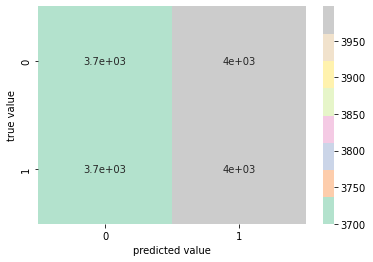

In [94]:
# confusion matrix
print(confusion_matrix(y_valid_class,y_pred_valid_class))
sns.heatmap(confusion_matrix(y_valid_class,y_pred_valid_class),annot=True,cmap='Pastel2')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

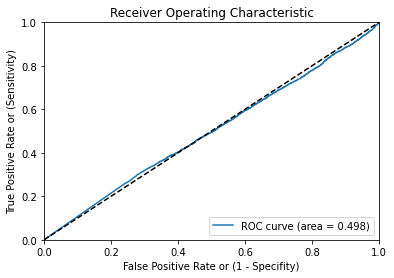

In [95]:
# auroc 
plot_ROC(y_valid_class,tf_pred_prb_valid)

##### explore valid dataset structure

In [96]:
# transformations
X_scaler_valid = scaler.fit_transform(valid_X)
X_normalized_valid = normalize(X_scaler_valid)

# dimention reduction
pca = PCA(n_components=2, svd_solver='randomized', whiten=True, random_state=1000)
X_principal_valid = pd.DataFrame(pca.fit_transform(X_normalized_valid))
X_principal_valid.columns = ['PC1','PC2']

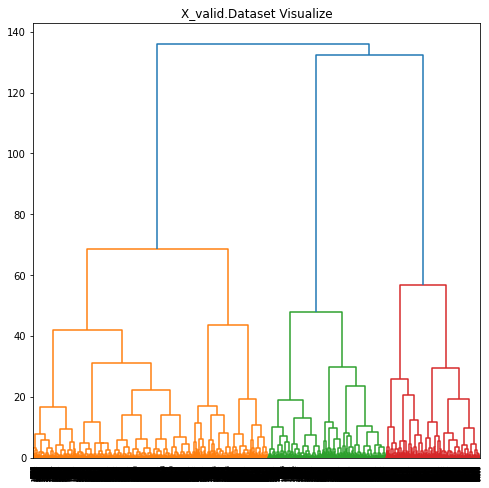

In [97]:
# view dendrograms
plt.figure(figsize=(8,8))
plt.title("X_valid.Dataset Visualize")
Dendrogram = shc.dendrogram(shc.linkage(X_principal_valid, method='ward'))

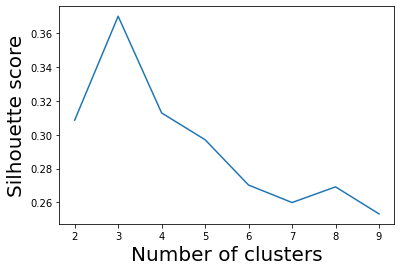

In [98]:
# build k clustering models
sil_scores_valid = []
for k in range(2,10):
    ac = AgglomerativeClustering(n_clusters=k)
    score = silhouette_score(X_principal_valid, ac.fit_predict(X_principal_valid))
    sil_scores_valid.append(score)

# plotting
k=[i for i in range(2,10)]
plt.plot(k,sil_scores_valid)
plt.xlabel("Number of clusters", fontsize=20)
plt.ylabel("Silhouette score", fontsize=20)
plt.show()

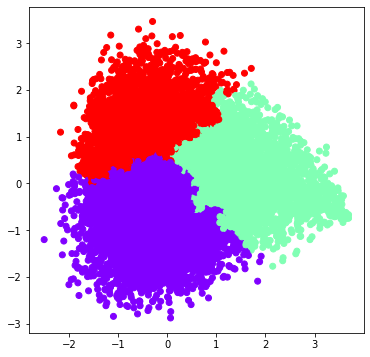

In [99]:
# apply the optimal k number as 3
ac3 = AgglomerativeClustering(n_clusters=3)

# Visualize the cluster
plt.figure(figsize=(6,6))
plt.scatter(X_principal_valid['PC1'], X_principal_valid['PC2'],
           c=ac3.fit_predict(X_principal_valid), cmap='rainbow')
plt.show()